# Decoding by Quantum Interferometry

In this tutorial, we will show you the Qrisp implementation of the [Optimization by Decoded Quantum Interferometry](https://arxiv.org/abs/2408.08292) and its relevant subroutines.  
This algorithm is rigorously derived in the original paper, including motivation with physical intuition, so we highly recommend giving it a read!  

Additionally, the 2025 paper [Quantum Circuit Design for Decoded Quantum Interferometry](https://arxiv.org/abs/2504.18334) goes into circuit design for this algorithm (as the title suggests) and is worth investigating as well!  
We will cross-reference these two papers throughout the text where applicable, so you know where to look for specific details.
Let us quickly summarize what the original paper is about:

The **Decoded Quantum Interferometry (DQI)** algorithm uses the **quantum Fourier transform** to arrange amplitudes so that they interfere constructively on symbol strings with high objective values. This increases the probability of measuring good solutions. The procedure effectively reduces optimization problems to decoding problems.
Specifically, sparse unstructured optimization problems such as **max-k-XORSAT** are reduced to decoding of **low-density parity-check (LDPC)** codes.
Let us dive into how this works with the example of the **max-XORSAT** problem, which is defined as follows:

You are given a system of $ m $ XOR (exclusive OR) equations over $ n $ binary variables: $x_{i_1} \oplus x_{i_2} \oplus \dots \oplus x_{i_k} = b_j$,
where:

- $x_i \in \{0, 1\}$ are Boolean variables,  
- $\oplus$ denotes addition modulo 2 (XOR),  
- $b_j \in \{0, 1\}$ are fixed constants,  
- each equation (or clause) involves a subset of variables.  

The goal in **max-XORSAT** is to find an assignment to the variables $ x_i $ that maximizes the number of satisfied XOR equations.

The max-XORSAT problem can be rephrased as maximizing the objective function $f(\mathbf{x}) = \sum_{i=1}^{m} (-1)^{v_i + \mathbf{b}_i \times \mathbf{x}}$ where $\mathbf{b}_i$ is the $i$-th row of $B$, a matrix in which each row represents one of the XOR equations. So $ f(\mathbf{x}) $ is the number of linear equations that are satisfied minus the number of unsatisfied ones.

Now, the **Hadamard transform** of this function will be sparse. Only for the strings $\mathbf{b}_1, \ldots, \mathbf{b}_m$ the amplitudes will be nonzero, so we only have $ m $ nonzero amplitudes in total. So if we can prepare the superposition $\sum_{i=1}^{m} (-1)^{v_i} \ket{\mathbf{b}_i}$
and apply the Hadamard transform, then we will arrive at $\sum_{\mathbf{x} \in \{0,1\}^{\otimes n}} f(\mathbf{x}) \ket{\mathbf{x}}$

This state is then biased towards higher objective-value strings $\mathbf{x}$.  
With a higher amplitude and objective value $f(\mathbf{x})$, they are more likely to be measured.
A slight bias is obviously not enough — but how can we improve this?  
The answer is by introducing a polynomial $P$ to encode our function $f$, turning it into a **decoding problem**.

This **polynomial encoding** with $P$ amplifies amplitude differences between basis states based on their objective values, by reweighting the amplitudes and introducing higher-order correlations in the Hadamard basis.  
When an initial superposition $f(\mathbf{x}) \ket{\mathbf{x}}$ would encode the objective value linearly (i.e., measuring $\ket{\mathbf{x}}$ is proportional to its amplitude $f(\mathbf{x})$), a degree-2 polynomial can encode the objective value **quadratically**. When the resulting state $\ket{P(f)}$ is measured in the computational basis, a string $\mathbf{x}$ is obtained with probability proportional to $P(f(x))^2$.  
We therefore want to prepare the state

$$
\ket{P(f)} = \sum_{\mathbf{x} \in \{0,1\}^{\otimes n}} P(f(\mathbf{x})) \ket{\mathbf{x}}
$$

Interpreting $P(f)$ as a decoding function gives us a recipe for the necessary **uncomputation**:  
The state encodes phase information similar to a **syndrome**, i.e., an erroneous state within the context of quantum error correction (more on this in the uncomputation section).  

The process of preparing this state requires inferring the error vector $\ket{y}$ from the syndrome $B^T \mathbf{y}$ and uncomputing $\ket{y}$ in superposition — which is precisely the task of **syndrome decoding** for a linear error-correcting code.  
So in this step, we will employ well-known techniques from this field.

As a further note, the higher the degree $ l $ of the polynomial $ P $, the greater the bias toward measured bit strings with large objective values. This powerful encoding, however, introduces a **fundamental trade-off**: the polynomial degree $ l $ must be chosen such that it corresponds to the maximum number of errors the underlying decoding system can correct — meaning a larger $ l $ requires solving a harder decoding problem.

For the max-XORSAT case, the derivation of $\ket{P(f)}$ can be found on [p. 19 in the first paper](https://arxiv.org/abs/2504.18334#page=19).

## Steps in the algorithm

### Preparing the State $\ket{P(f)}$

To arrive at the state $\ket{P(f)}$, five steps are conducted.  
The first one is to prepare a **Dicke state superposition** $\sum_{k=0}^{l} w_k \ket{D_{m,k}}$, where

$$
\ket{D_{m,k}} = \frac{1}{\sqrt{\binom{m}{k}}} \sum_{|y| = k} \ket{\mathbf{y}}
$$

i.e. the Dicke state of weight $k$.  
See our [Dicke state tutorial](../tutorial/DickeStatestutorial.ipynb) on how this is implemented in Qrisp.  
The coefficients $w_k$ emerge as the **principal eigenvector** of a matrix built in relation to the expected number of satisfied constraints. Please refer to *Lemma 9.2* in the [DQI paper](https://arxiv.org/pdf/2408.08292) to see how we can define this matrix. The weights will then be fanned out via **unary amplitude encoding**. 
We will touch on this again in the implementation section.

The next step is to consider the **problem-specific phase** $(-1)^{\mathbf{v} \cdot \mathbf{y}}$ via conditional $Z$-gates. Recall that $\mathbf{v}$ emerges from the initial equation $B \mathbf{x} = \mathbf{v}$ that we are trying to solve. Then, the problem matrix will be encoded into the second register, such that we receive the state $\ket{B^T \mathbf{y}}$ as part of our superposition.  
After this step, we will have the state

$$
\sum_{k=0}^{l} w_k \frac{1}{\sqrt{\binom{m}{k}}} 
\sum_{|y| = k} (-1)^{\mathbf{v} \cdot \mathbf{y}} 
\ket{\mathbf{y}} \ket{B^T \mathbf{y}}
$$

Now, at this point, we want to refer again to the **biased polynomial** $\ket{P(f)}$, which encodes problem solutions with high likelihood. Its **Hadamard transform** will always be of the form:

$$
H^{\otimes n} \ket{P(f)} = 
\sum_{k=0}^{l} w_k \frac{1}{\sqrt{\binom{m}{k}}} 
\sum_{|y| = k} (-1)^{\mathbf{v} \cdot \mathbf{y}} \ket{B^T \mathbf{y}}
$$

So after the previous step of encoding the problem matrix $B$, we are just one **uncomputation** of $\ket{\mathbf{y}}$ (and a straightforward Hadamard transform) away from our desired polynomial state $\ket{P(f)}$.

### Uncomputation and Decoding

Unfortunately, said uncomputation is the hard part of the algorithm. With the structure of $B$, this turns the task into a **decoding problem**, a problem studied in the context of, e.g., low-density parity-check matrices for error correction.

In error correction we deal with so-called stabiliser codes to facilitate error correction. When one measures the stabilisers of a quantum error-correcting code, a binary outcome vector is obtained that indicates which parity checks have been violated and thus signals the presence and location of errors. These so-called *syndromes* are the result of multiplying the error vector by the transpose of the parity-check (or stabiliser) matrix. In the DQI algorithm, one interprets the matrix $B^T \mathbf{y}$ as the parity-check operator and the state $\ket{B^T \mathbf{y}}$ holds the syndrome, which is then decoded to infer $y$ (the “error pattern”) and thus enables the uncomputation step that biases the quantum amplitudes toward good solutions.

Without going into much detail, we want to mention three approaches to tackle this problem for our purposes here, which are also considered in the [original DQI paper](https://arxiv.org/abs/2408.08292), namely: [Belief Propagation](https://arxiv.org/pdf/2102.01984), Look-Up tables (see [Decoding methods](https://en.wikipedia.org/wiki/Decoding_methods)), and the quantum version of a Gauss–Jordan elimination (see [quant-ph/0511062](https://arxiv.org/pdf/quant-ph/0511062)).

Our solution relies on the quantum version of a Gauss–Jordan elimination, which lies somewhere in the middle of belief propagation and look-up tables in terms of efficiency and resource demand.  
You might ask yourself: What is Gauss–Jordan elimination? And how do we make it quantum? That is a great question, so let’s answer it!

A [Gauss–Jordan elimination](https://en.wikipedia.org/wiki/Gaussian_elimination) is used to bring a matrix into reduced row echelon form, i.e., applying row operations until you have reached the reduced upper-triangular form. In the case of an invertible matrix, one computes its inverse in this way. For our purpose, this inversion property effectively results in the isolation of a syndrome in the corresponding augmented matrix, i.e., the problem matrix extended by the syndrome vector. We will see what this looks like in the implementation part. You can find more information on the Quantum Gauss–Jordan Elimination and its use in syndrome decoding in the [thesis on Independent Set Decoding (S. Perillo et al.)](https://www.politesi.polimi.it/retrieve/ef311c33-5427-4869-865f-94dc5ee733ed/Thesis.pdf#page=92).

Our DQI implementation does not employ a fully quantum Gauss–Jordan elimination but translates the classical row-operation steps into quantum gates acting on the syndrome register.
Since $B$ is classical, we can precompute the required transformations and map them to quantum gates — classical swaps become [swap()](../../reference/Primitives/generated/qrisp.swap.rst) gates, and additions become [cx()](../../reference/Primitives/generated/qrisp.cx.rst) gates. This approach minimizes resource overhead and avoids failure in the case of a non-invertible matrix.

It is important to note here that our chosen routine may still produce erroneous uncomputations, and we need to post-select on the correct ones. The latter are characterized by the respective register being measured as all $\ket{0}$.


# DQI Implementation in Qrisp


Now that we have covered the theoretical aspect of the algorithm, let us jump into our implementation! We want to remind you again, that the theoretical aspects of the DQI procedure are very complex, and we can only cover so much here. So, if there are any questions left unanswered, we strongly recommend taking the time to read the [original paper by S. Jordan et. al.](https://arxiv.org/abs/2408.08292) 
Let’s reiterate — the algorithm consists of five main steps executed on two registers: the **error register** and the **syndrome register**, as shown below

<img src="../../_static/dqi_state_manipulation.png" class="align-center" width="1200" alt="DQI algorithm steps" />

The complete process to prepare the desired polynomial-encoded state $\ket{P(f)}$ consists of the following steps:

1. **Prepare the correctly weighted Dicke state**

   $$
   \sum_{k=0}^{l} w_k \ket{D_{m,k}}
   $$

2. **Encode the problem-specific phases**

   $$
   \sum_{k=0}^{l} w_k \frac{1}{\sqrt{\binom{m}{k}}}
   \sum_{|y| = k} (-1)^{\mathbf{v} \cdot \mathbf{y}}
   \ket{\mathbf{y}} \ket{B^T \mathbf{y}}
   $$

3. **Encode the constraints given by the problem matrix**

   $$
   \sum_{k=0}^{l} w_k \frac{1}{\sqrt{\binom{m}{k}}}
   \sum_{|y| = k} (-1)^{\mathbf{v} \cdot \mathbf{y}} \ket{\mathbf{y}}
   $$

4. **Uncompute the syndrome quantum state**

   $$
   \sum_{k=0}^{l} w_k \frac{1}{\sqrt{\binom{m}{k}}}
   \sum_{|y| = k} (-1)^{\mathbf{v} \cdot \mathbf{y}}
   \ket{B^T \mathbf{y}}
   $$

5. **Apply a Hadamard transform**

   $$
   \sum_{x} P(f(x)) \ket{x}
   $$

6. **Post-select on correctly uncomputed states**


Before we tackle these steps, let us explain how we define the quantum registers:
We operate on two different quantum registers, which in the context of Qrisp may be represented by any sort of multi-qubit QuantumVariable (or other type). Multiple registers, i.e. variables, may then be grouped within a [QuantumArray](../../reference/Core/QuantumArray.rst).
The first register, which is in the literature referred to as the error register, will be represented by a QuantumVariable ``qv_error`` of size $n$. On the second register we will apply the matrix operations resulting from the Quantum Gauss-Jordan-Elimination, see the **uncomputation steps described above**. 
As mentioned previously, this routine operates on an augmented matrix, namely the transposed problem matrix augmented by the syndrome quantum state. And as you probably guessed, there is some functionality for that in Qrisp!
It requires using a ``QuantumArray`` though, so the syndrome register, which we name ``qv_syndrome`` will be represented by a ``QuantumArray`` of length $m$ consisting of single-qubit [QuantumVariables](../../reference/Core/QuantumVariable.rst).

We start our implementation by looking at the unary amplitude encoding of the error register. As mentioned in the theoretical overview, the amplitudes to encode emerge as the principal eigenvector of a matrix related to 
the expected number of satisfied constraints, which is defined in Lemma 9.2 of the [DQI paper](https://arxiv.org/pdf/2408.08292):
It is depended on a number of parameters: We have $m$ as the number of constraints, i.e. the number of rows in the problem matrix. The prime $p$ defines our finite field $\mathbb{F}_p$, which is set to $p=2$ in the case of max-XORSAT. Additionally, $r=1$ represents number of inputs yielding $+1$. $l$ can be chosen to be equal to $2$, or as an optimized version. For more information, see the [DQI paper](https://arxiv.org/pdf/2408.08292).

We now construct this matrix and solve for its principal eigenvector.
(Note: This function is adapted from [N. Patamawisut's github repo](https://github.com/BankNatchapol/DQI-Circuit/tree/main).




In [1]:

import numpy as np
from scipy.sparse.linalg import eigsh
from scipy.sparse import diags
def get_optimal_w(m, l, p, r):

    # define the parameter d
    d    = (p - 2*r) / np.sqrt(r * (p - r))
    # create the main diagonal and the two offdiagonals as numpy arrays.
    diag = np.arange(l + 1) * d
    off  = np.sqrt(np.arange(1, l + 1) * (m - np.arange(1, l + 1) + 1))

    A = diags([off, diag, off], offsets=(-1, 0, 1), format="csr")

    # solve for principal eigenvector
    _, vecs = eigsh(A, k=1, which="LA")
    w = vecs.flatten()
    
    # pad the weights list that is returned, s.t. it is a power of 2
    orig = len(w)
    pad_len = 2**int(np.ceil(np.log2(l+1)))
    weights = list(w)
    weights += [0 for i in range((pad_len -orig)) ]
    return weights

Next, we need to encode these amplitudes into the state to create $\sum_k w_k \ket{k}$. A simple fan-out strategy based on [ry()](../../reference/Primitives/generated/qrisp.ry.rst)-gates will do the trick.

In [2]:
from qrisp import ry, control
def uae_encoding(qa_error, num_constraints, weights):
    
    # Normalize weights
    weights = weights/sum(weights)
    w2 = weights  
    
    # Calculate the cumulative
    cum = np.concatenate(([0.0], np.cumsum(w2[:-1])))  
    denom = 1.0 - cum

    # Avoid division by zero, clip ratios
    ratio = np.where(denom > 0, w2 / denom, 0.0)
    ratio = np.clip(ratio, 0.0, 1.0)
    betas = 2.0 * np.arccos(np.sqrt(ratio))

    # Actual encoding 
    # Apply first RY if nonzero
    if betas[0] != 0.0 and not np.isnan(betas[0]):
        ry(betas[0], qa_error[0][0])
    # Controlled rotations
    for i in range(1, num_constraints):
        if i < betas.size:
            b = betas[i]
            if b != 0.0 and not np.isnan(b):
                with control( qa_error[i-1][0]):
                    ry(b,  qa_error[i][0])


Then we prepare a Dicke state superposition, i.e. further transform the state into $\sum^{l}_{k=0} w_k \frac{w_k }{\sqrt{\binom{m}{k}}} \sum_{ | y | = k} \ket{\textbf{y}}$.
Now this would require quite a bit of effort in any other framework. But with Qrisp, we already have according functionality in place! Which renders this as easy as calling the [dicke_state()](../../reference/Primitives/DickeStates.rst) function (or any of its variations)! We will revisit this in the complete implementation example and omit the detailed construction here.
The subsequent step is conceptually simple and requires little additional explanation. The phase encoding applies a phase shift to the error register based on the constraint vector $\mathbf{v}$, yielding $$\sum^{l}_{k=0} w_k \frac{w_k }{\sqrt{\binom{m}{k}}} \sum_{ | y | = k} (-1)^{\textbf{v} \cdot \textbf{y}} \ket{\textbf{y}}$$


In [3]:
from qrisp import z
def specific_phase_encoding(qa_error, v):

    for index in range(len(v)):
        if v[index] == 1:
            z(qa_error[index])

The last transformation before we tackle the complex decoding steps is to encode the problem matrix. 
By applying [cx()](../../reference/Primitives/generated/qrisp.cx.rst)-gates conditioned on the binary $B^T$ matrix entries, we will receive the state $$\sum^{l}_{k=0} w_k \frac{w_k }{\sqrt{\binom{m}{k}}} \sum_{ | y | = k} (-1)^{\textbf{v} \cdot \textbf{y}} \ket{\textbf{y}} \ket{B^T \textbf{y}}$$


In [4]:
from qrisp import cx
def constraint_encoding(qa_error, qv_syndrome, B):

    # reverse indices due to circuit definition
    qa_error, qv_syndrome = qa_error[::-1], qv_syndrome[::-1]

    # create B^T
    B_t = np.transpose(B)

    # encode constraints
    i_ind, j_ind = B_t.shape
    for i in range(i_ind):
        for j in range(j_ind):
            if  B_t[i][j] == 1: 
                cx(qa_error[j], qv_syndrome[i])

    return qa_error, qv_syndrome

### Decoding implementation in Qrisp


We now arrive at the decoding step, corresponding to the uncomputation of $\ket{y}$. To perform this, we require a quantum version of the Gauss–Jordan elimination.
Our implementation follows the approach proposed by N. Patamawisut et al. in their 2025 paper [Quantum Circuit Design for Decoded Quantum Interferometry](https://arxiv.org/abs/2504.18334). A code example can be found on [their github repository](https://github.com/BankNatchapol/DQI-Circuit/tree/main).
Considering the resources given by their research and the simplicity of the code we will not go into large detail on what happens here. If anything remains unclear, do not hesitate to reach out to us! (Or the original authors)
What this code does in essence is to calculate the necessary operations to bring the classical input matrix to [reduced row echelon form (rref)](https://en.wikipedia.org/wiki/Row_echelon_form). These may be a series of row swaps or row additions. A series of quantum operations is then returned, where the swaps are replaced by [swap()](../../reference/Primitives/generated/qrisp.swap.rst) gates and the additions by [cx()](../../reference/Primitives/generated/qrisp.cx.rst) gates, applied to the column which augments the matrix, i.e. the syndrome register ``qv_syndrome``, as shown in the next step. 


In [5]:
def gauss_jordan_operations_general(matrix):

    m = len(matrix)
    num_cols = len(matrix[0])
    n = num_cols - 1  # last column is RHS
    # work on a copy
    mat = [row.copy() for row in matrix]
    operations = []
    pivot_row = 0
    pivot_col = 0
    # perform Gauss-Jordan procedure
    while pivot_row < m and pivot_col < n:
        # find pivot in this column at or below pivot_row
        pivot_idx = None
        for r in range(pivot_row, m):
            if mat[r][pivot_col] == 1:
                pivot_idx = r
                break
        if pivot_idx is None:
            pivot_col += 1
            continue

        # swap into pivot position if needeAd
        if pivot_idx != pivot_row:
            # append the correct operations
            operations.append(('swap', pivot_row, pivot_idx))
            mat[pivot_row], mat[pivot_idx] = mat[pivot_idx], mat[pivot_row]

        # eliminate other rows
        pivot_data = mat[pivot_row]
        for r in range(m):
            if r != pivot_row and mat[r][pivot_col] == 1:
            # append the correct operations
                operations.append(('xor', pivot_row, r))
                # XOR rows from pivot_col onward
                row_r = mat[r]
                row_r[pivot_col:] = [a ^ b for a, b in zip(row_r[pivot_col:], pivot_data[pivot_col:])]

        pivot_row += 1
        pivot_col += 1

    return operations, mat

The following ``syndrome_decoding`` function is then the application of the gates extracted in the previous step, applied to the correct qubits from the syndrome register.

In [6]:
from qrisp import cx, swap
def syndrome_decoding(matrix, qv_syndrome):

    if isinstance(matrix, np.ndarray):
        mat_list = matrix.tolist()
    # extract the gates resulting from the Gauss-Jordan elimination 
    ops, mat = gauss_jordan_operations_general(mat_list)
    num_qubits = len(mat_list)

    # apply the gates on the syndrome register
    for op_type, src, tgt in ops:
        if op_type == "swap":
            swap(qv_syndrome[src][0], qv_syndrome[tgt][0])
        elif op_type == "xor":
            cx(qv_syndrome[src][0], qv_syndrome[tgt][0])
    
    return mat , qv_syndrome

**Attention!** This decoding procedure may result in erroneous decodings. We only want to consider the states, where the decoding was succesful. Since for a correctly decoded syndrome the error register will be in the all $\ket{0}$-state this is easily achieved by post-selecting our final results on the measurement of the error register being all $0$s. This can also be seen when we check our final results later on.
The only remaining step is to apply a Hadamard transform, after which the procedure is complete.
We can now use these building blocks to solve an actual optimization problem.

## DQI example for max-XORSAT

The following section illustrates the internal workings of the [DQI()](../../reference/Algorithms/DQI.rst) function. The subroutines shown below are encapsuled in this function and will be exectuded upon calling it.

As a final example, let us revisit the entire workflow and apply it to solve a max-Cut optimization problem. We start by defining the problem matrix $B$ and the solution constraints $\textbf{v}$, which consists entirely of ones, since any solution is valid.

In [7]:
B = np.array([
    [0, 1, 1, 1, 1, 0],
    [1, 0, 0, 0, 1, 1],
    [1, 0, 0, 1, 0, 0],
    [1, 0, 1, 0, 1, 1],
    [1, 1, 0, 1, 0, 1],
    [0, 1, 0, 1, 1, 0]
    ])

v = np.array([1, 1, 1, 1, 1, 1],) 


This will result in the following graph:

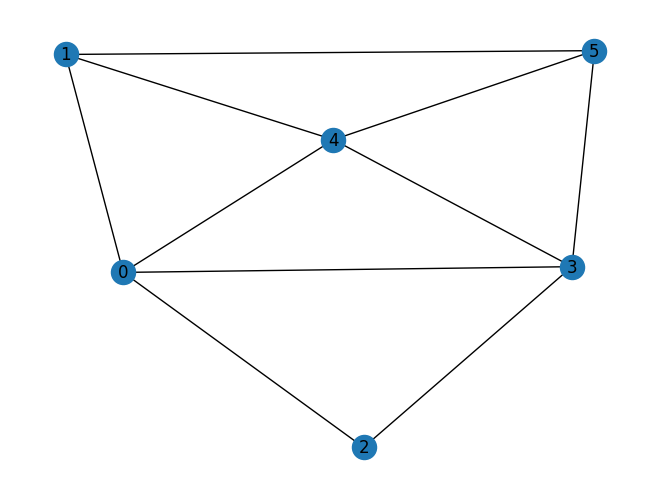

In [8]:
import networkx as nx
G = nx.from_numpy_array(B)
nx.draw(G, with_labels=True)
import matplotlib.pyplot as plt
plt.show()

Let us go through the routine.
We start by defining our two [QuantumArrays](../../reference/Core/QuantumArray.rst) ``qa_error`` and ``qa_syndrome``, representing the error and syndrome register respectively.

In [9]:
from qrisp import QuantumFloat, QuantumArray
m = B.shape[0]
q_type = QuantumFloat(1, 0)
qa_error = QuantumArray(qtype= q_type , shape=(m,))

# create syndrome quantumArray
qa_syndrome = QuantumArray(qtype= q_type , shape=(m,))

Next, we prepare the correctly weighted Dicke state.
The function ``get_optimal_w`` is used to compute the weight coefficients. We call it with the default arguments for a max-XOR-SAT instance. ``uae_encoding`` distributes them across the error register ``qa_error``. A final call to the ``dicke_state`` preparation routine then produces the desired superposition state.

In [10]:

# default arguments for MAX-XOR-SAT
p=2  
r=1
l=2
princ_eigenvec = get_optimal_w(m,l,p,r)

# UAE encoding encoding
uae_encoding(qa_error, m, princ_eigenvec)


from qrisp.alg_primitives.dicke_state_prep import dicke_state
dicke_state(qa_error[::-1], len(qa_error)) 

We continue with the problem specific encodings, namely the specific phase encoding and constraint encoding, via the respective ``specific_phase_encoding`` and ``constraint_encoding`` functions. 


In [11]:
# phase encoding
specific_phase_encoding(qa_error, v)

# constraint encoding
qa_error, qa_syndrome = constraint_encoding(qa_error, qa_syndrome, B)

We have now reached the core of the algorithm — the decoding step.
As explained earlier, we apply the classical Gauss–Jordan elimination procedure ``syndrome_decoding`` and extract the corresponding quantum gates to be applied to the syndrome register ``qa_syndrome``.

In [12]:
syndrome_decoding(B.T, qa_syndrome)

([[1, 0, 0, 0, 1, 1],
  [0, 1, 0, 0, 0, 1],
  [0, 0, 1, 0, 0, 0],
  [0, 0, 0, 1, 1, 1],
  [0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0]],
 <qrisp.core.quantum_array.QuantumArray at 0x21ae6ce4590>)

We then further encode these actions on the error register ``qa_error``

In [13]:
for i in range(m):
    cx(qa_syndrome[i], qa_error[i]) 

And we invert the ``syndrome_decoding`` step for proper uncomputation.

In [14]:
from qrisp import invert
with invert():
    syndrome_decoding(B.T, qa_syndrome)

The last step is then the aforementioned Hadamard-transformation.

In [15]:
from qrisp import h
h(qa_syndrome)   

And finally, we measure and post-select on the correctly uncomputed error register, i.e. the ones where the ``qa_error`` is in all $\ket{0}$.

In [16]:
from qrisp import multi_measurement

# get all correct solutions
res_dict = multi_measurement([qa_error,qa_syndrome])

corr_sols_dqi = {}
max_val = max(res_dict.values())
for key,val in res_dict.items():
    cor_val = True
    for i in range(len(key[0])):
        if key[0][i]!= 0:
            cor_val = False
            break
    if cor_val:
        #print(key, val)  
        corr_sols_dqi.setdefault(''.join(map(str, key[1])),val)

print(corr_sols_dqi)

{'000101': 0.09361249779996442, '010110': 0.09361249779996442, '100011': 0.09361249779996442, '110000': 0.09361249779996442, '000010': 0.01663726619625907, '000110': 0.01663726619625907, '001110': 0.01663726619625907, '001111': 0.01663726619625907, '010001': 0.01663726619625907, '010101': 0.01663726619625907, '011100': 0.01663726619625907, '011101': 0.01663726619625907, '100000': 0.01663726619625907, '100100': 0.01663726619625907, '101000': 0.01663726619625907, '101001': 0.01663726619625907, '110011': 0.01663726619625907, '110111': 0.01663726619625907, '111010': 0.01663726619625907, '111011': 0.01663726619625907, '000000': 0.0018070289124625918, '010011': 0.0018070289124625918, '100110': 0.0018070289124625918, '110101': 0.0018070289124625918, '000001': 0.00068001088017408, '000100': 0.00068001088017408, '001000': 0.00068001088017408, '001001': 0.00068001088017408, '001100': 0.00068001088017408, '001101': 0.00068001088017408, '010010': 0.00068001088017408, '010111': 0.00068001088017408,

Et voilá! We have executed all steps to find an optimal solution to the maxCut problem via the DQI algorithm! 

## Checking the results

Let us now examine the results.
We aim to compare them with a brute-force solution. The following can also be found in [Patamawisut's github repository](https://github.com/BankNatchapol/DQI-Circuit/blob/main/src/dqi/utils/solver.py>), where he provides a similar plot for his solution. For our purpose we need quite a few adjustements, so the full function is provided at the end of this tutorial as supplementary material. It is lengthy, but dont fret, you can use it out of the box! 

What we can see here is a comparison between the likelyhood of a result appearing as a result of our DQI algorithm, plotted against to objective value of a solutions aquired via brute force.
The left $x$-axis, corresponding to the blue curve, represents the objective value of each bitstring, whereas the right $x$-axis describes the measurement probabilities for each bitstring in our final post-selected state. Those are plotted as red bars. On the $y$-axis we have every possible 6-digit bitstring.
Remarkably, all high objective value results appear with the highest likelyhood among our post-selected states!

<img src="../../_static/dqi_result_plot.png" class="align-center" width="1600" alt="DQI results v. brute force" />

Congratulations, you have implemented the full version of the DQI algorithm and are now able to tackle optimization problems all on your own and can investigate the results with adequate vizualisation! Check out the next section for suggestions on where to go from here.


## Further reading


The interested reader has many avenues to explore, starting with other use cases from the [DQI paper](https://arxiv.org/abs/2408.08292), namely general LINSAT and OPI. These have not yet been implemented in Qrisp — if you are interested in contributing or need guidance, feel free to reach out!
Another promising avenue is the belief propagation approach to syndrome decoding, which, according to the original work, appears to offer the best potential for achieving true quantum advantage with the DQI algorithm.
Should you be interested in resource analysis, we again refer to [Patamawisut's paper](https://arxiv.org/abs/2504.18334), where he gives a detailed description on all aspects of the algorithm.

You have reached the end of the tutorial, we hope you had alot of fun! If you would like to explore Qrisp more, go have a look at our other tutorials! 


## References

[1] [Natchapol Patamawisut et al., *Quantum Circuit Design for Decoded Quantum Interferometry*, 2025, arXiv: 2504.18334](https://arxiv.org/abs/2504.18334)

[2] [S. Jordan et al., *Optimization by Decoded Quantum Interferometry*, 2024, arXiv: 2408.08292](https://arxiv.org/abs/2408.08292)


## Supplementary material


**Note**: The functions found below are an adjusted versions from the ones found in [N. Patamawisut's github repo](https://github.com/BankNatchapol/DQI-Circuit/tree/main), 
They include the function used to create the combined histogram and spline plot shown in Figure 2.

To use this function, evaluate your DQI instance to obtain the final state, then post-select on the $\ket{0}$ state in the ``qa_error`` register. Additional supplementary functions are provided below, including the brute-force solver used for comparison.

In [17]:

from itertools import product
from typing import Callable, List, Tuple, Dict

import matplotlib.pyplot as plt
def _enumerate_solutions(num_vars: int,score_fn: Callable[[Tuple[int, ...]], int]):

    results = []
    for bits in product([0,1], repeat=num_vars):
        results.append((bits, score_fn(bits)))
    # sort so best scores come first
    results.sort(key=lambda x: x[1], reverse=True)
    return results


def max_xorsat_all_solutions(G: nx.Graph) -> Tuple[List[Dict[int,int]], int]:

    def score(bits: Tuple[int,...]) -> int:
        return sum((bits[i] ^ bits[j]) == 1 for i, j in G.edges())

    raw = _enumerate_solutions(G.number_of_nodes(), score)
    best_score = raw[0][1]
    # collect all assignments tying that best_score
    best = [bits for bits, s in raw if s == best_score]
    return ([{i: bits[i] for i in range(len(bits))} for bits in best], best_score)


def brute_force_max(B: np.ndarray, v: np.ndarray) -> List[Tuple[str,int]]:

    m, n = B.shape

    def score(bits: Tuple[int,...]) -> int:
        x = np.array(bits, dtype=int)
        return int(np.sum((-1)**(B.dot(x)+v)))

    raw = _enumerate_solutions(n, score)
    # return sorted ascending by bitstring integer (you can re-sort here if you like)
    # or leave descending by score—choose whichever API you prefer
    return [("".join(map(str,bits)), sc) for bits, sc in raw]


brute_force_results = brute_force_max(B, v)

And below you can find the function to create the plot spline/histogram plot for the result comparison!

In [18]:

from scipy.interpolate import UnivariateSpline
def plot_results_union_matplotlib(
    brute_force_results: List[Tuple[str, int]],
    dqi_results: Dict[str, int],
    plot_name: str = "Comparison of DQI and True Objective Values",
    
    spline_smoothing: float = 1.0,
    left_axis_margin: float = 0.2,  # fraction of max to leave above the curve
    x_label_rotation: float = 60 
) -> None:
    """
    Dual-axis Matplotlib chart: brute-force objective vs. DQI probability.
    Secondary axis centered on 0 to align with primary axis.
    Primary axis has a tighter cutoff near the max value.
    """
    if not brute_force_results:
        raise ValueError("brute_force_results must be non-empty")

    # determine full bit-length from brute-force labels
    full_len = len(brute_force_results[0][0])

    # normalize DQI keys
    norm_dqi: Dict[str, int] = {}
    for key, count in dqi_results.items():
        parts = key.split()
        if len(parts) == 2:
            prefix, suffix = parts
        else:
            prefix, suffix = "", parts[0]
        bits = suffix
        if len(bits) < full_len:
            bits = "0" * (full_len - len(bits)) + bits
        full_bits = (prefix + " " + bits) if prefix else bits
        norm_dqi[full_bits] = norm_dqi.get(full_bits, 0) + count
    
    prefix = ""
    if dqi_results:
        key_split = list(dqi_results.keys())[0].split(" ")
        if len(key_split) == 2:
            prefix = "0"*len(key_split[0]) 
    bf_dict = {f"{prefix} {label}".strip(): val for label, val in brute_force_results}
    for bits in norm_dqi:
        if bits not in bf_dict:
            bf_dict[bits] = 0

    # union of all labels
    all_keys = set(bf_dict) | set(norm_dqi)
    sorted_keys = sorted(all_keys, key=lambda k: int(k.replace(" ", ""), 2))

    # prepare series
    bf_values  = [bf_dict.get(k, 0) for k in sorted_keys]
    ext_counts = [norm_dqi.get(k, 0) for k in sorted_keys]
    total_ext  = sum(ext_counts)
    ext_probs  = [(c / total_ext) if total_ext else 0 for c in ext_counts]

    x = np.arange(len(sorted_keys))

    # start plot
    fig, ax1 = plt.subplots(figsize=(14, 5))

    # spline smoothing for bf_values if more than 3 points
    if len(x) > 3:
        spline = UnivariateSpline(x, bf_values, s=spline_smoothing*len(x))
        x_smooth = np.linspace(x.min(), x.max(), 10000)
        bf_smooth = spline(x_smooth)
        
        # clip spline to original min/max
        bf_smooth = np.clip(bf_smooth, min(bf_values), max(bf_values))
        
        ax1.plot(x_smooth, bf_smooth, color="blue", label="Objective Value")
    else:
        ax1.plot(x, bf_values, color="blue", label="Objective Value")

    # set tighter y-axis using clipped spline
    ax1.set_ylim(min(bf_values) - 0.05*abs(min(bf_values)),
                max(bf_smooth) + left_axis_margin*max(bf_values))

    ax1.fill_between(x_smooth, bf_smooth, color="blue", alpha=0.2)
    ax1.set_ylabel("Objective Value", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")

    # tighter y-axis range for left axis
    bf_max = max(bf_values) if bf_values else 1
    bf_min = min(bf_values) if bf_values else 0
    ax1.set_ylim(-(bf_max + bf_max*left_axis_margin), bf_max + bf_max*left_axis_margin)

    # secondary axis for DQI probabilities
    ax2 = ax1.twinx()
    
    # make secondary y-axis symmetric around 0
    dqi_max = max(ext_probs) if ext_probs else 0.1
    #ax2.set_ylim(-dqi_max- dqi_max*0.2, dqi_max+ dqi_max*0.2)
    ax2.set_ylim(-dqi_max - dqi_max*0.2 , dqi_max+ dqi_max*0.2)
    # plot bars centered on 0
    ax2.bar(x, ext_probs, alpha=0.6, color="red", label="DQI (Probability)", bottom=0)

    ax2.set_ylabel("Probability (DQI)", color="red")
    ax2.tick_params(axis="y", labelcolor="red")

    ax1.set_xticks(x)
    ax1.set_xticklabels(sorted_keys, rotation=x_label_rotation, ha="right")
    ax1.set_title(plot_name)

    # combine legends
    lines, labels = ax1.get_legend_handles_labels()
    bars, blabels = ax2.get_legend_handles_labels()
    ax1.legend(lines + bars, labels + blabels, loc="upper center", ncol=2)

    plt.tight_layout()
    plt.show()

And the appropriate function call:

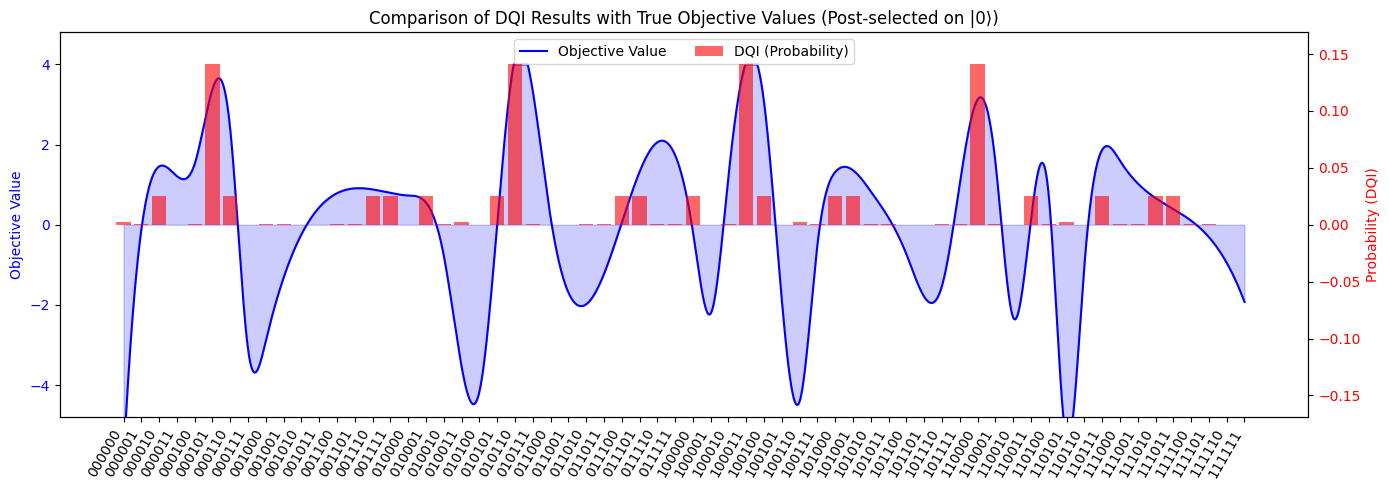

In [19]:
plot_results_union_matplotlib(
    brute_force_results,
    corr_sols_dqi,
    plot_name="Comparison of DQI Results with True Objective Values (Post-selected on |0⟩)",
    spline_smoothing=1.3
)